## Importing libraries and files

In [1]:
import pandas as pd
from keras.models import load_model
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


ann_arr = load_model('RP_Arrival_time/Arrival_ANN4')
ann_end = load_model('RP_End_time/End_ANN1')
ann_chg = load_model('RP_Change_time/Change_ANN2')
ann_trg = load_model('RP_Trough_time/Trough_ANN2')

#Section1
ann1 = load_model('RP_Section_1_new3/Section1_new3_ANN_2')
sc1 = pickle.load(open('RP_Section_1_new3/Section1_new3_scaler_ANN_2.pkl', 'rb'))
#Section2
ann2 = load_model('RP_Section_2_new2/Section2_new_ANN_2')
sc2 = pickle.load(open('RP_Section_2_new/Section2_new_scaler_ANN_2.pkl', 'rb'))
#Section3
ann3 = load_model('RP_Section_3_new/Section3_new_ANN_1')
sc3 = pickle.load(open('RP_Section_3_new/Section3_new_scaler_ANN_1.pkl', 'rb'))
#Section4
ann4 = load_model('RP_Section_4_new/Section4_new_ANN_1')
sc4 = pickle.load(open('RP_Section_4_new/Section4_new_scaler_ANN_1.pkl', 'rb'))
#Section5
ann5 = load_model('RP_Section_5_new/Section5_new_ANN_1')
sc5 = pickle.load(open('RP_Section_5_new/Section5_new_scaler_ANN_1.pkl', 'rb'))
#Section6
ann6 = load_model('RP_Section_6_new/Section6_new_ANN_1')
sc6 = pickle.load(open('RP_Section_6_new/Section6_new_scaler_ANN_1.pkl', 'rb'))

D:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Input details

In [41]:
Mass = 17.3
Standoff_distance = 4.5
Angle = 40
termination_time = 40
interval = 0.1

## Pressure Profile

In [42]:
#values1 = []
#values2 = []
#values3 = []
arr = np.array ([[Mass,Standoff_distance, Angle]])

arrival_time = ann_arr.predict(arr)
end_time = ann_end.predict(arr)
change_time = ann_chg.predict(arr)
trough_time = ann_trg.predict(arr)

print ("arrival", arrival_time, "end", end_time, "change", change_time, "trough", trough_time)

def stable_state(start, end, interval):    
    t = np.arange(start, end + interval, interval)
    t = t.reshape(len(t),1)

    p = np.repeat(0, len(t)).reshape(len(t),1)
    
    values = np.concatenate ((t, p), axis = 1)
    return values

def p_fluctuation(standoff_distance, d_set):
    if 1.5 <= standoff_distance <= 3:
        d_set[:,0:4] = sc1.transform(d_set[:,0:4])
        p_f = ann1.predict(d_set)
        section = 1
        
    elif 3 < standoff_distance <= 7:
        d_set[:,0:4] = sc2.transform(d_set[:,0:4])
        p_f = ann2.predict(d_set)
        section = 2
        
    elif 7 < standoff_distance <= 13:
        d_set[:,0:4] = sc3.transform(d_set[:,0:4])
        p_f = ann3.predict(d_set)
        section = 3
        
    elif 13 < standoff_distance <= 19:
        d_set[:,0:4] = sc4.transform(d_set[:,0:4])
        p_f = ann4.predict(d_set)
        section = 4
        
    elif 19 < standoff_distance <= 25:
        d_set[:,0:4] = sc5.transform(d_set[:,0:4])
        p_f = ann5.predict(d_set)
        section = 5
        
    elif 25 < standoff_distance <= 30:
        d_set[:,0:4] = sc6.transform(d_set[:,0:4])
        p_f = ann6.predict(d_set)
        section = 6
        
    else:
        print ("Out of trained range")
    return p_f, section

'''def p_fluctuation2(d_set):
    d_set[:,0:4] = sc2.transform(d_set[:,0:4])
    p_f = ann2.predict(d_set)
    
    return p_f'''

if termination_time < arrival_time:
    start = 0
    end = termination_time
    values1 = stable_state(start, end, interval)
    arrival_time = 0
    end_time = 0

else:
    start = 0
    end = arrival_time
    values1 = stable_state(start, end, interval)
    
    if termination_time < end_time:
        end_time = termination_time
        
    else:
        start = end_time
        end = termination_time
        values3 = stable_state(start, end, interval)

t2= np.arange(arrival_time, end_time + interval, interval)
t2 = t2.reshape(len(t2),1)

if t2[0] < change_time:
    ph2 = np.array([[0, 1]])
else:
    ph2 = np.array([[1, 0]])
    
positive = np.array([0, 1])
negative= np.array([1, 0])

for time in t2[1:]:
    if time < change_time:
        ph2=np.vstack((ph2,positive))
    else:
        ph2=np.vstack((ph2,negative))
        
m2 = np.repeat(Mass, len(t2)).reshape(len(t2),1)
d2 = np.repeat(Standoff_distance, len(t2)).reshape(len(t2),1)
a2 = np.repeat(Angle, len(t2)).reshape(len(t2),1)
d_set = np.concatenate ((m2, d2, a2, t2, ph2), axis = 1)

#p2 = p_fluctuation(Standoff_distance, d_set)
p2, section = p_fluctuation(Standoff_distance,d_set)
p2 = p2.reshape((-1, 1))
values2 = np.concatenate ((t2, p2), axis = 1)


if 'values2' in globals():
    ml_model = np.concatenate((values1, values2), axis=0)
    if 'values3' in globals():
        ml_model = np.concatenate((ml_model, values3), axis=0)
else:
    ml_model = values1
print (section)

1/1 [==============================] - 0s 24ms/step
arrival [[6.73543]] end [[23.072443]] change [[11.72647]] trough [[20.472422]]
6/6 [==============================] - 0s 3ms/step
2


In [43]:
file_path = Path(f'H:/Chamodi/LSDYNA/Reflected_pressure/RP_Comparison_with_Numerical/{Standoff_distance}m{Mass}kg/9')
lsdyna = pd.read_csv(file_path, delimiter="\s+", skiprows = 8, skipfooter = 1, header = None, names = ["Time", "Pressure"])

Time_adj = 2
Pressure_adj = 101.25

lsdyna['Time'] = (lsdyna['Time']*1000)+ Time_adj
lsdyna['Pressure'] = (lsdyna['Pressure']/1000)- Pressure_adj

C:\Users\z5379606\AppData\Local\Temp\ipykernel_28400\3708063071.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  lsdyna = pd.read_csv(file_path, delimiter="\s+", skiprows = 8, skipfooter = 1, header = None, names = ["Time", "Pressure"])


In [ ]:
file_path = Path('H:/Chamodi/LSDYNA/Reflected_pressure/RP_Comparison_with_Numerical/4.5m17.3kg/8.xlsx')
lsdyna = pd.read_excel(file_path, names = ["Time", "Pressure"])

lsdyna['Time'] = (lsdyna['Time']*1000)
lsdyna['Pressure'] = (lsdyna['Pressure']/1000)

X2 = lsdyna['Time']
y2 = lsdyna['Pressure']

[ 454  830  900  926  977 1072]


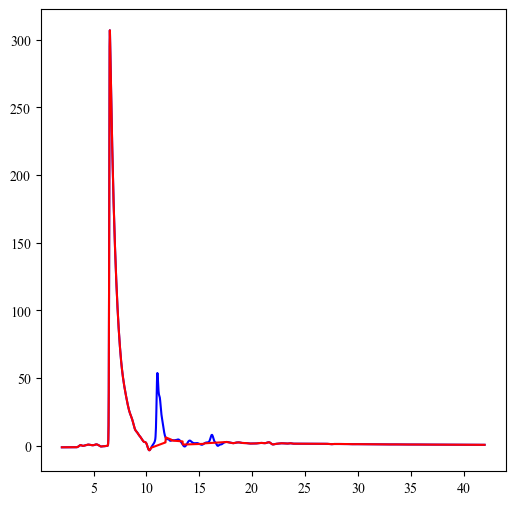

In [44]:
X2 = lsdyna['Time']
pressure = lsdyna['Pressure']


from scipy.signal import find_peaks

# Identify peaks with tolerance parameters
height_threshold = 3  # Minimum height of peaks to detect
prominence = 0.01  # Minimum prominence of peaks in pressure units
width = 6  # Minimum width of peaks in time units

# Find peaks
peaks, properties = find_peaks(pressure, height=height_threshold, prominence=prominence, width=width)
print (peaks)

# Ensure there are at least two peaks
if len(peaks) >= 1:
    #first_peak_index = peaks[0]

    # Create a copy of pressure data to modify
    smoothed_pressure = np.copy(pressure)

    # Define a window around each peak after the first peak to apply smoothing
    window_radius_r = 60
    window_radius_l = 30 # Adjust the window radius as needed

    for peak_index in peaks[1:]:
        start = max(peak_index - window_radius_l, 0)
        end = min(peak_index + window_radius_r + 1, len(pressure))

        # Extract values just outside the window
        if start > 0 and end < len(pressure):
            start_value = pressure[start - 1]
            end_value = pressure[end]
        elif start > 0:
            start_value = pressure[start - 1]
            end_value = start_value
        elif end < len(pressure):
            end_value = pressure[end]
            start_value = end_value
        else:
            start_value = end_value = np.mean(pressure)  # Fallback in case there are no valid points

        # Create a linearly spaced array between start_value and end_value
        interpolated_values = np.linspace(start_value, end_value, end - start)

        # Apply the interpolated values to the points within the window
        smoothed_pressure[start:end] = interpolated_values
        
y2 = smoothed_pressure

plt.figure(figsize=(6,6))
plt.plot(lsdyna['Time'], lsdyna['Pressure'], color = 'blue',label = 'Numerical')
plt.plot(lsdyna['Time'], y2, color = 'red',label = 'Numerical')
plt.show()

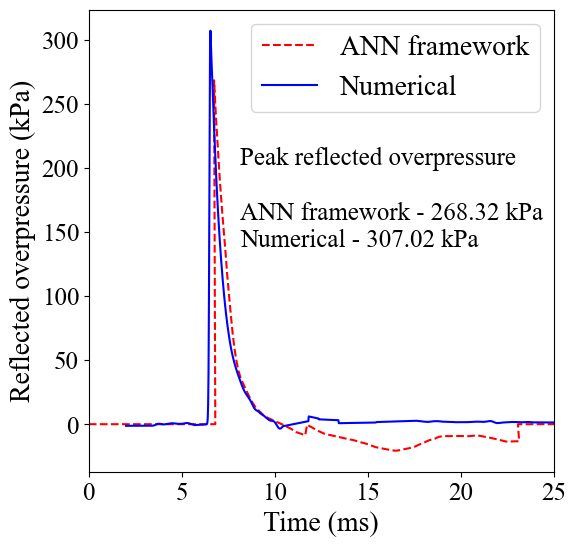

In [45]:
X1 = ml_model[:,0]
y1 = ml_model[:,1]


plt.figure(figsize=(6,6))
plt.rcParams["font.family"] = "Times New Roman"
plt.plot(X1, y1, linestyle = 'dashed', color = 'red', label = 'ANN framework')
plt.plot(X2, y2, color = 'blue',label = 'Numerical')
plt.ylabel('Reflected overpressure (kPa)',fontsize = 20)
plt.xlabel('Time (ms)',fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 20)

# Create the annotation text
annotation_text = (f'Peak reflected overpressure\n\nANN framework - {round(max(y1), 2)} kPa\n'
                   f'Numerical - {round(max(y2), 2)} kPa')

plt.annotate(annotation_text,xy=(0.4,0.5), xycoords='figure fraction', fontsize=18)
plt.xlim (0, 25)
plt.savefig(f'RP_Num&ANN_Comparison/Section{section}_{Standoff_distance}m{Mass}kg/{Angle}deg1.png', dpi=150, bbox_inches='tight')
plt.show()